## 모듈 import

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


### 데이터셋 구성

- **tf.keras** 안에 있는 **datasets**에 cifar10 데이터셋을 load 합니다.


- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.


- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.


- tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

cifar 10 데이터는 32x32x3 픽셀의 이미지 데이터로 각 픽셀은 0~255의 정수값을 가집니다.

In [32]:
print("min pixel:", train_x.min())
print("max pixel:", train_x.max())

min pixel: 0
max pixel: 255


CIFAR-10에 어떤 이미지가 있는지 확인해 봅시다.

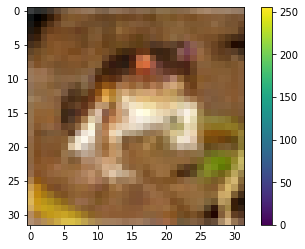

In [33]:
plt.imshow(train_x[0].reshape(32,32,3))

plt.colorbar()
plt.show()

imshow의 RGB 데이터의 경우 0-1까지 이여서 보여지는 colorbar에선 -1이 없네요.  
좀 더 많은 데이터를 확인해 볼까요

열 개 정도를 한 번에 띄워보겠습니다.

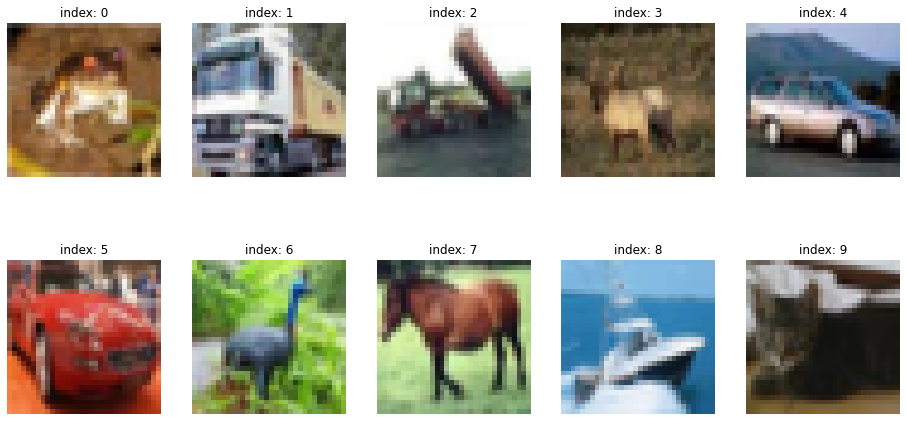

In [34]:
plt.figure(figsize=(16, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

위의 CIFAR-10 이미지를 랜덤하게 20개 정도 출력 해보겠습니다.

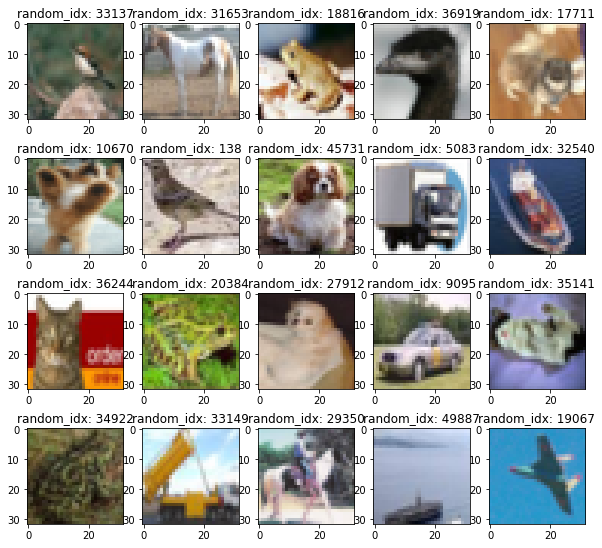

In [35]:
plt.figure(figsize=(10, 12))

for i in range(20):
    rand_int =  np.random.randint(50000)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[ rand_int].reshape(32, 32,3))
    plt.title(f'random_idx: {rand_int}')
plt.show()

#### train_x 이미지  [-1, 1]로 정규화

In [3]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 합니다.

print('min pixel : ', train_x.min())
print('max pixel : ', train_x.max())

min pixel :  -1.0
max pixel :  1.0


In [4]:
# 다시 shape를 확인해 봅시다.
train_x.shape

(50000, 32, 32, 3)

cifar-10의 데이터셋에 5만장의 이미지와, 32x32의 이미지 크기, RGB 채널을 가진것을 확인할 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'random_idx: 36774')

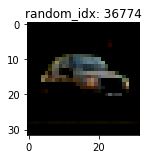

In [38]:

plt.figure(figsize=(20, 12))

rand_int =  np.random.randint(len(train_x) )
plt.subplot(5, 5, i+1)
plt.imshow(train_x[ rand_int].reshape(32, 32,3))
plt.title(f'random_idx: {rand_int}')

RGB데이터의 범위가 [0..1이]여서 음수 값은 표현이 안된다는 메시지가 뜹니다.
범위를 [0, 1]로 바꾼 후 다시 이미지를 표현해 봅시다.

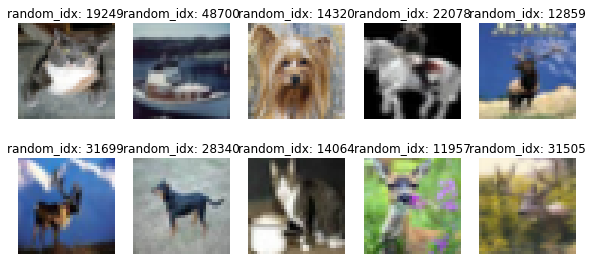

In [39]:
plt.figure(figsize=(10, 12))
# ((train_x[ rand_int]+1)/2)으로 범위를 [0,2] /2-> [0,1]로 범위를 바꾼다.  
for i in range(10):
    rand_int =  np.random.randint(len(train_x) )
    plt.subplot(5, 5, i+1)
    plt.imshow(((train_x[ rand_int]+1)/2.0).reshape(32, 32,3))  # [-1,1] -> [0.1]
    plt.title(f'random_idx: {rand_int}')
    plt.axis('off') # 축 안보이도록
plt.show()

이제 위의 정리된 데이터를 가지고 모델에 넣어서 학습시켜야 합니다.  
좀 더 편하게 사용할 수 있도록 텐서플로우의 **Dataset**을 이용해 준비해 놓도록 하겠습니다. 

In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

**BUFFER_SIZE**은 전체 데이터를 섞기 위해 50,000으로 설정합니다. **shuffle()** 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.


**BATCH_SIZE**는 모델이 한 번에 학습할 데이터의 양입니다.  
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 **mini batch learning** 이라고 합니다.

**tf.data.Dataset** 모듈의 **from_tensor_slices()** 함수를 사용해서 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---


## 생성자 모델 구현하기



- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.


- **noise = tf.random.normal([1, 100])**로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.


- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.



In [7]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

**make_generator_model**이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했습니다.

함수 내부에서는 먼저 **tf.keras.Sequential()**로 모델을 시작한 후 **Conv2DTranspose** 레이어를 model에 add해서 쌓아줍니다.

여기에서 가장 중요한 레이어는 바로 **Conv2DTranspose** 레이어입니다.  
Conv2DTranspose층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다. 이 모델에서는 세 번의 **Conv2DTranspose** 층을 이용해 **(8, 8, 256) → (16, 16, 64) → (32, 32, 3)** 순으로 이미지를 키워나갑니다. 여기서 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일합니다.

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

생성자 모델이 만들어졌으니, **shape=(1, 100)**의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보도록 하겠습니다.
아직 모델이 학습되지 않았으니, 결과물도 큰 의미가 있지는 않을 것입니다.

**tf.random.normal**을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

In [9]:
noise = tf.random.normal([1, 100])

텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 (내부적으로는 생성자의 **call** 함수가 호출됩니다).

단, 지금은 학습하는 중이 아니니 **training=False**를 설정해 주어야 합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 **training=False**을 주어야 올바른 결과를 얻을 수 있습니다.

In [32]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

**[1, 32, 32, 3]** 사이즈의 이미지가 생성이 되었습니다.
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

그러면 이 이미지를 시각화해서 보겠습니다.  


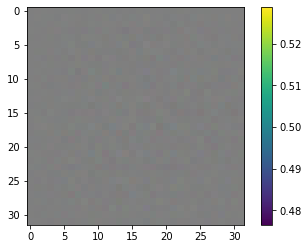

In [69]:
# ((train_x[ rand_int]+1)/2)으로 범위를 [0,2] /2-> [0,1]로 범위를 바꾼다.  
plt.imshow(((generated_image[0, :, :, :]+1)/2.0))
plt.colorbar()
plt.show()

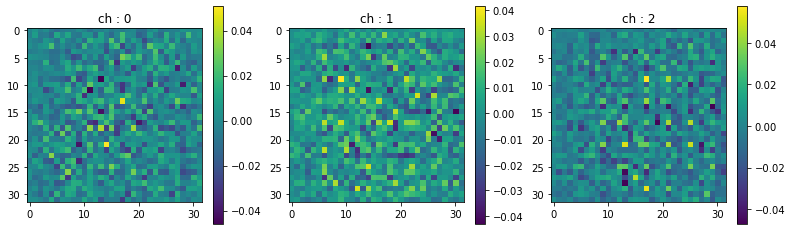

In [73]:

plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1, 4, (i+1))
    plt.imshow(generated_image[0, :, :, i])  # [-1,1] -> [0.1]
    plt.title('ch : {}'.format(i))
    plt.colorbar()
plt.show()

모델의 픽셀이 [-1, 1] 사이의 값에서 생성된 것을 확인할 수 있습니다.    
정규화를 통해 범위를 [-1, 1]로 정했지만, image의 픽셀값은 0,1의 이미지가 들어와야 하기 때문에 위에서 처럼 ` +1)/2.0 `을 해줍니다. 


아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가면서 점차 나은 이미지를 만들어갈 것입니다. 

## 판별자 모델 구현하기
---
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.  


- 위에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.


In [10]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자 또한 **make_discriminator_model** 함수로 구현을 합니다.

**Conv2DTranspose** 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 **Conv2D** 층으로 이미지의 크기를 점점 줄여나갑니다.
첫 번째 Conv2D 층에서 입력된 **[32, 32, 3]** 사이즈의 이미지는 다음 층을 거치며 **(32, 32, 3) → (16, 16, 64) → (8, 8, 128)**까지 줄어들게 됩니다.

마지막에는 **Flatten** 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 3x8x8x128=24579, 즉 (3, 8192) 형상의 벡터로 변환합니다.  
이는 생성자의 **Reshape** 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 **Dense** Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

그럼 판별 모델을 **discriminator**라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해 봅시다.

In [11]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

위에서 noies와 생성자를 이용해 만들었던 가짜 이미지를 판별자에 입력시켰을때의 결과를 확인해 봅시다

In [76]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0035833]], dtype=float32)>

생성자로 만든 이미지가 의미가 없는 데이터 였기에 판별자의 결과도 아직은 아무런 의미가 없는 값입니다.

## 손실함수와 최적화 함수 구현하기
---

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.  

교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, **이진 교차 엔트로피(binary cross entropy)**를 사용할 것입니다.


그렇다면 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.

- **생성자** : 판별자가 Fake Image에 대해 판별한 값, 즉 **D(fake_image)** 값이 1에 가까워지는 것


- **판별자** : Real Image 판별값, 즉 **D(real_image)**는 **1**에, Fake Image 판별값, 즉 **D(fake_image)**는 **0**에 가까워지는 것


tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다.  

따라서 **from_logits**를 **True**로 설정해 주어야 **BinaryCrossEntropy**에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

- **from_logits**를 **False**로 한 후 마지막 출력층에서 **`activation='sigmoid'`**로 하는 방법도 있습니다.   
그렇지만, 위의 방법으로 하는것보다 **from_logits=True**로 하는것이 더 안정적인 결과를 가집니다.

### cross_entropy
**cross_entropy**를 활용해 계산할 loss들은 **fake_output**와 **real_output**, 두 가지를 활용합니다.

- **fake_output** : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값,  


- **real_output** : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값,  

### generator_loss
- 생성자의 대한 loss 함수를 구현해 봅시다.

**generator_loss**는 **fake_output**가 1에 가까워지기를 바라므로, 다음과 같이 **tf.ones_like**와의 교차 엔트로피값을 계산하면 됩니다.  

즉, **cross_entropy(tf.ones_like(fake_output), fake_output)** 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def generator_loss(fake_output) :  
    # fake_output이 real image와 비슷할 수록 작은 값을 가진다. 
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

반면, **discriminator_loss**는 **real_output** 값은 1에 가까워 지는 것,  **fake_output** 값은 0에 가까워지는 것을 바라므로, 두 가지 loss값을 모두 계산합니다. **real_output**은 1로 채워진 벡터와, **fake_output**은 0으로 채워진 벡터와 비교하면 됩니다.

최종 **discriminator_loss** 값은 이 둘을 더한 값입니다.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss+fake_loss

#### discriminator accuracy

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다.  

그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

- 0.5에 가까워야하는 이유는 0.5에 가까울 수록 모델이 진짜인지 가짜인지 반반이라는 의미이기에 0.5에 가까워지는것이 좋은 모델이다.

In [15]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.

ex.) real_output = tf.Tensor([0.1, 0.7, 0.2, 0.9]) 라면,

- (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
     - `>> tf.Tensor([False, True, False, True])`
   
   
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    - `>> tf.Tensor([0.0, 1.0, 0.0, 1.0 ])`
    
    
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    - `>> 0.5`


-> 0.5에 가까울 수록 이상적인 생성자가 된다.

### 최적화 함수(optimizer)
---

이제 최적화 함수를 설정하겠습니다.  
가장 기본적인 최적화 기법으로 **Adam 최적화 기법**을 활용하겠습니다.


중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [16]:
lr_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, epsilon=1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, epsilon=1e-4, beta_1=0.5)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.  
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.  
즉, 100차원의 노이즈를 총 16개, **(16, 100)** 형상의 벡터를 만들어 두도록 하겠습니다.

In [17]:
noise_dim = 100
num_examples_to_generate = 16

# seed 값 고정 
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기
---

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.  


- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.


- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.


- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### train_step() 함수

학습시킬 훈련 함수 위에 **@tf.function** 이라는 데코레이터를 붙여서 사용합니다. 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줍니다.

- **`@tf.function`** 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.

In [18]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        # real_output : 실제 이미지의 output 
        real_output = discriminator(images, training=True)
        # fake_output : generator 한 이미지의 output
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 fake_output과 real_output으로 계산
        #  -- > 거짓을 확실히 거짓이라고 확신을 못내는 진짜와, 가짜를 혼동한 결과가 잘 학습된 결과이다.
        #  0.5
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    # gen_tape와 disc_tao룰 활용해서 gradient를 자동으로 계산한다.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    #  오차역전파(Backpropagation) optimizer에 입력해서 가중치를 업데이트한다.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

**`train_step`** 함수를 하나하나 뜯어보면 다음과 같습니다.

- (1) 입력데이터: Real Image 역할을 할 **images** 한 세트를 입력으로 받음


- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 **noise**를 **images** 한 세트와 같은 크기인 **BATCH_SIZE** 만큼 생성함


- (3) **tf.GradientTape()**는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 **with** 구문 열기


- (4) generated_images 생성 : generator가 **noise**를 입력받은 후 **generated_images** 생성


- (5) discriminator 판별 : discriminator가 Real Image인 **images**와 Fake Image인 **generated_images**를 각각 입력받은 후 **real_output**, **fake_output** 출력


- (6) loss 계산 : **fake_output**, **real_output**으로 generator와 discriminator 각각의 loss 계산


- (7) accuracy 계산 : **fake_output**, **real_output**으로 discriminator가


- (8) gradient 계산 : **gen_tape**와 **disc_tape**를 활용해 gradient를 자동으로 계산


- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신


- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴


이러한 일련의 과정을 통해 한 번의 **train_step**이 끝나게 됩니다.

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 봅시다.

아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [84]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, ]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

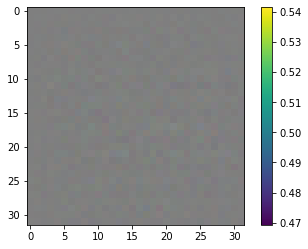

In [87]:
#generate_and_save_images(, epoch+1, it+1, seed)
predictions = generator(seed, training=False)
predictions.shape[0]
i=1

plt.imshow((predictions[i, :, :, ]+1)/2.0)
plt.colorbar()

위의서 고정한 seed의 개수가 16개이므로 4행 4열로 나누어 **1subplot(4, 4, i+1)1**로 시각화합니다.

또한, **plt**에 저장되어 보여지는 이미지를 **plt.savefig**로 간단히 파일화 해서 저장합니다.

**train_step()** 함수가 리턴하는 **gen_loss**, **disc_loss**, **real_accuracy**, **fake_accuracy** 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리하겠습니다.

### draw_train_history() 함수 구현

- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 함수를 구현해 봅시다.

In [89]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.  

checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장합니다.  

checkpoint 모델을 저장하기 위해 작업환경 내에 **training_checkpoints** 라는 디렉토리를 사용하겠습니다.

In [90]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 과정 진행하기
---

- 위에서 구현한 기능들을 활용하여 최소 모델 학습을 진행해 봅시다.  


- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.  


checkpoint 모듈을 이용해 모델을 저장하고 나중에 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 코드 입니다.

---

``` python
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.
```

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다

``` python

%%time
train(train_dataset, EPOCHS, save_every)

```

### 모델학습하는 train 함수

한 단계를 학습하는 **train_step**, 샘플 이미지를 생성하고 저장하기 위한 **generate_and_save_images()**, 학습 과정을 시각화하는 **draw_train_history()**, 그리고 모델까지 저장하기 위한 **checkpoint**까지 모두 준비가 되었으니 이것들을 한 곳에 모아 함수로 만들겠습니다.

In [19]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

그러면 모델을 저장하는 간격을 담당하는 **save_every**와 전체 학습 에포크를 결정하는 **EPOCHS** 파라미터도 설정해준 후 훈련시켜 보도록 하겠습니다!

In [92]:

save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

위에까지 준비가 다 되었으면 학습을 실행 합니다.

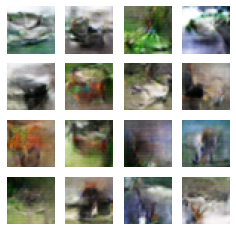

Time for training : 5974 sec


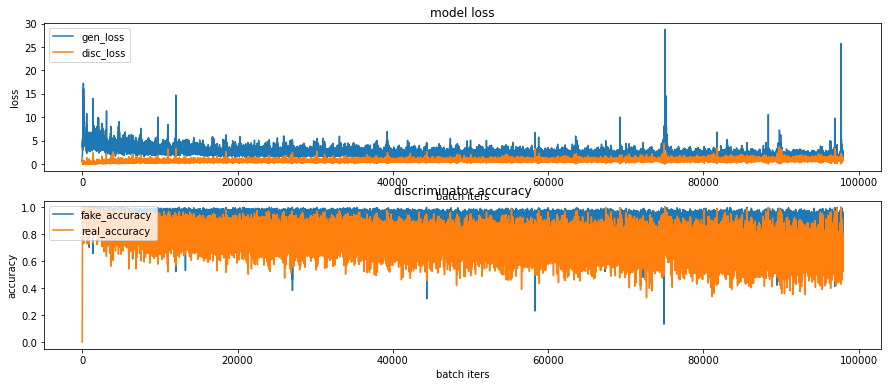

CPU times: user 1h 39min 52s, sys: 3min 25s, total: 1h 43min 17s
Wall time: 1h 39min 37s


In [96]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

<br>

모델의 학습을 길게 했지만 제대로된 이미지가 생성이 안된것 같네요.  
뒤에서 네트워크 구조와 파라미터를 변경하면서 그럴듣한 이미지를 생성해 봅시다.  

### 학습과정 시각화하기
---
학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보겠습니다. 

In [16]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac27 ssac27 1303238 Feb 18 14:07 /home/ssac27/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![cifar10_dcgan.gif](./img/cifar10_dcgan.gif)

GIF 이미지도 생성이 완료 되었습니다!!    

GAN을 좀 더 다른 구조로 만들거나 다음어서 더 좋은 결과가 나오게 만들어 봅시다

## (optional) GAN 훈련 과정 개선하기

- 위의 과정들을 다시 되짚어 보고 파라미터와 구조 재설계를 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.



- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)도 표시해 봅시다.



위의 그래프를 보면 **discriminator_accuracy**가 1에 가깝습니다.  
그래프의 의미 : fake_image와 real_image의 차이가 커서 판별자가 구분을 쉽게 한다.

위의 문제를 해결하기 위해 **optimizer**나 모델의 구조 변경 등의 과정을 진행합니다.

<br>

- 위의 과정에서 각 단계별로 왜 그런 단계를 해야하는지와 그 단계에 대한 설명이 있으므로,   
개선한 훈련 과정을 간략하게 나타내겠습니다. 

####  References : [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://jonathan-hui.medium.com/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)
<br>
<br>

## 1차 파라미터 조정및 모델 구조 조정
위의 내용을 참조하고 개인적으로 생각해서 모델의 구조를 변경했습니다.  

**위 내용 참조**
- LeakyReLU의 alpha를 0.0002
- generator의 ReLU 적용
- Adam의 beta_1값 0.5   
- 모델의 Batch_size는 128

--- 
  
**판단**
-  Dense layer에 ReLU 적용시 다음 레이어부터 음수값의 관한 부분을 제대로 학습 못한다고 생각해서 해당 layer에만 LeakyReLU를 적용했습니다.

- Dropout 대신 BatchNormalization 사용

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 합니다.

print('min pixel : ', train_x.min())
print('max pixel : ', train_x.max())

min pixel :  -1.0
max pixel :  1.0


In [4]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 128  # mini-batch 256,

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델
- generator에선 LeakyReLU 대신 ReLU를 사용합니다.

In [36]:
def make_generator_model():
    n_nodes = 8*8*256
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))  


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))

    return model

In [37]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)        

## 판별자 모델 

In [40]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    # 3: Flatten Layer
    model.add(layers.Flatten())

    # 4: Dense Layer
    model.add(layers.Dense(1))

    return model

In [41]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

---

### generator_loss

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True )

In [7]:
def generator_loss(fake_output) :  
    # fake_output이 real image와 비슷할 수록 작은 값을 가진다. 
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_los

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss+fake_loss

### discriminator accuracy

In [9]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

---

### 최적화 함수(optimizer)

In [46]:
lr_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1=0.5)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 16개의 샘플을 확인하고 매번 같은 noise를 사용해야 하므로 seed를 고정하겠습니다.

**(16, 100)**

In [11]:
noise_dim = 100
num_examples_to_generate = 16

# 고정된 seed 값 
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

### train_step() 함수
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

In [11]:
@tf.function # 데코레이터로 session의 열고 닫는것을 내부적으로 처리
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        # real_output : 실제 이미지의 output 
        real_output = discriminator(images, training=True)
        # fake_output : generator 한 이미지의 output
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 fake_output과 real_output으로 계산
        #  -- > 거짓을 확실히 거짓이라고 확신을 못내는 진짜와, 가짜를 혼동한 결과가 잘 학습된 결과이다.
        #  0.5
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    # gen_tape와 disc_tao룰 활용해서 gradient를 자동으로 계산한다.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    #  오차역전파(Backpropagation) optimizer에 입력해서 가중치를 업데이트한다.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값



### generate_and_save_images
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 

In [49]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, ]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/v2_generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### draw_train_history()

- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 함수

In [50]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/v2_training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [51]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/v2_training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---

## 모델학습 train 함수


In [12]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [53]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

위에까지 준비가 다 되었으면 학습을 실행 합니다.

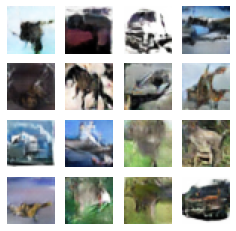

Time for training : 2838 sec


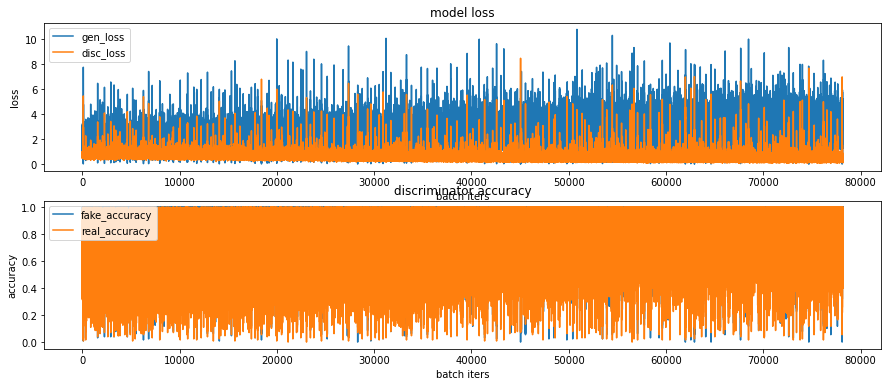

CPU times: user 48min 11s, sys: 1min 30s, total: 49min 42s
Wall time: 47min 21s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 
# ~/aiffel/dcgan_newimage/cifar10/v2_training_history 경로에 생성되고 있습니다.

In [3]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/v2_cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/v2_generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac27 ssac27 1303238 Feb 18 14:07 /home/ssac27/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![v2_cifar10_dcgan.gif](./img/v2_cifar10_dcgan.gif)

파라미터를 조정하기 전보다는 이미지들의 특징이 좀 더 눈에 띄게 되었습니다.  
**(1,3)의 트럭 앞 부분**, **(3,2)의 배의 앞 부분**, **(2,4)에선 보트**와 비슷한 모습이 보입니다. 

---

## 2차 파라미터 조장및 모델 구조 조정

- **2차 조정 부터는 바뀐 부분만 보이도록 하겠습니다.**

모델의 구조를 좀 더 깊게, 최종 이미지의 크기는 **[ 32,32,3 ]**의 사이즈를 갖지만 깊이는 더 깊은 모델을 만들어 봅시다.


- layer의 input을 **`8,8,256에서 -> 4,4,256`**으로 변경했습니다.


-  kernel_size를 1x1로 해서 non-linearity를 더 줍니다.


#### 파라미터의 수는 더 적지만, 더 깊은 모델을 만들어서 진행합니다.

<br>



---

In [13]:
def make_generator_model():
    n_nodes = 4*4*256
    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))

    # 2: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))  # 4,4 부터 32x32로 진행

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1)))
    
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=(1, 1)))
    
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=(1, 1)))
    
    #model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), padding='same', use_bias=False))

    
    # 6: Conv2DTranspose layer
#    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization(momentum=0.8))
#    model.add(layers.LeakyReLU(alpha=0.2))
    
    
    # 7: Conv2D - output layer 
    model.add(layers.Conv2D(3, kernel_size=(3, 3), padding='same',activation='tanh'))
    #model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))
    
    
    return model

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         16384     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       2

In [5]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    
    # 2: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))

    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    # 4: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))



    # 5: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # 6: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

### Optimizer 조정

In [17]:
lr_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1=0.5)

모델 체크포인트 설정

In [62]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/v3_training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---

모델과 Optimizer의 조정이 다 끝났으니 학습을 시작합니다.

In [63]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

위에까지 준비가 다 되었으면 학습을 실행 합니다.

epoch를 100번  반복한 결과 아래와 같다.

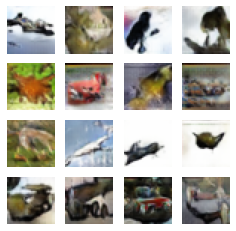

Time for training : 3359 sec


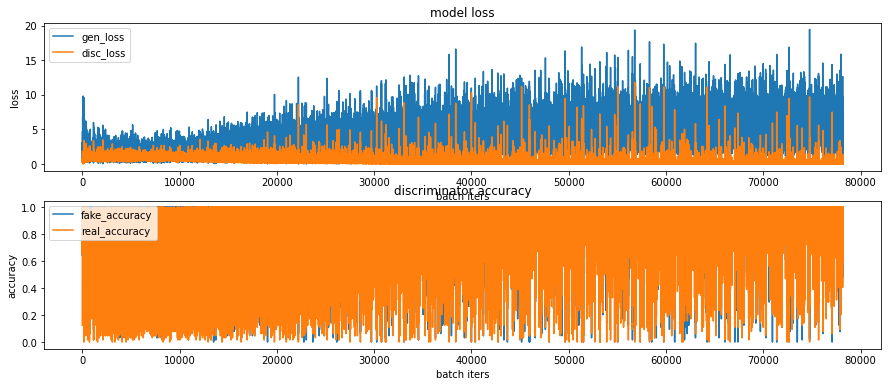

CPU times: user 26min 9s, sys: 1min 42s, total: 27min 52s
Wall time: 56min 3s


In [64]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 
# ~/aiffel/dcgan_newimage/cifar10/v3_training_history 경로에 생성되고 있습니다.

#### 비행기, 자동차, 배의 특징이 잘보이게 되었네요.

- 깊은 모델을 하니 이미지의 수행 시간이 더 빨라졌고 이미지들의 특징이 잘 보이게 되었습니다.  

- 여기서 생성된 이미지가 배, 비행기, 자동차 위주로 더 학습 된것 같네요.

In [4]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/v3_cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/v3_generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac27 ssac27 1303238 Feb 18 14:07 /home/ssac27/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![v3_cifar10_dcgan.gif](./img/v3_cifar10_dcgan.gif)

---

생각해 봤지만 결과가 좋지 않았던 모델 구조 :  
resNet의 Block을 생각해서 모델 구조를 만들어 봤지만 좋은 결과가 나오지는 않았습니다.

``` python
def make_generator_model():
    n_nodes = 4*4*256
    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))

    # 2: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))  # 4,4 부터 32x32로 진행

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, kernel_size=(1, 1), use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(1, 1), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, kernel_size=(1, 1), use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    # 7: Conv2D - output layer 
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same',activation='tanh'))
    #model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))
    
    return model
```

In [29]:
generator = make_generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              409600    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 4, 4, 128)         32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 8, 8, 128)         409600    
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 8, 8, 128)        

``` python
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    # 2: Conv2D Layer
    model.add(layers.Conv2D(64, (1, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (1, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))    

    
    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(128, (1, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (1, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    
    # 4: Conv2D Layer
    model.add(layers.Conv2D(256, (1, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (1, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))



    # 5: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))

    # 6: Dense Layer
    model.add(layers.Dense(1))

    return model

```

In [31]:
# 깊은 모델을 시도했지만 좋은 결과를 얻진 못했던 구조이다.
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        4160      
_________________________________________________________________
batch_normalization_39 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36864     
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 16, 64)       

## 3차 파라미터 조장및 모델 구조 조정

좀 더 색다른 방식으로 생각해서 진행해 봤습니다.  

train_step에 **generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))**를 2번 사용해서 한번의 학습에선 generator의 가중치를 2번 업데이트하고 discriminator를 1번 업데이트 하는 방식을 진행해 봤습니다.

---

In [13]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, ]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/v6_generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch+100, it))

    plt.show()

In [14]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/v6_training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch+101))
    plt.show()

Samples과 model의 저장될 폴더를 바꾼 후 모델 조정을 시작합니다.

---

In [21]:
def make_generator_model():
    n_nodes = 4*4*256
    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))

    # 2: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))  # 4,4 부터 32x32로 진행

    # 3: Conv2DTranspose layer

    model.add(layers.Conv2DTranspose(128, kernel_size=(6, 6), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.5))

    
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(6, 6), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.5))

    
    
    
    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(6, 6), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.5))

    
    
    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(6, 6), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.5))


    
    # 7: Conv2D - output layer 
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same',activation='tanh'))

    
    
    return model

In [22]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         1179648   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       589952    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)      

In [23]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))    


    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))



    # 4: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    # 5: Dense Layer
    model.add(layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73728     
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)        

---

### train_step

generate가 2번 학습할 때, discriminator 1번 학습  


In [27]:
@tf.function # 데코레이터로 session의 열고 닫는것을 내부적으로 처리
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        # real_output : 실제 이미지의 output 
        real_output = discriminator(images, training=True)
        # fake_output : generator 한 이미지의 output
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 fake_output과 real_output으로 계산
        #  -- > 거짓을 확실히 거짓이라고 확신을 못내는 진짜와, 가짜를 혼동한 결과가 잘 학습된 결과이다.
        #  0.5
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    # gen_tape와 disc_tao룰 활용해서 gradient를 자동으로 계산한다.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    #  오차역전파(Backpropagation) optimizer에 입력해서 가중치를 업데이트한다.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

---

모델과 Optimizer의 조정이 다 끝났으니 학습을 시작합니다.

In [22]:
save_every = 10
EPOCHS = 200

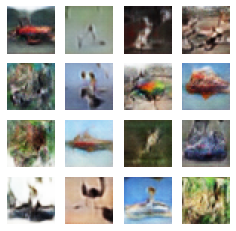

Time for training : 6827 sec


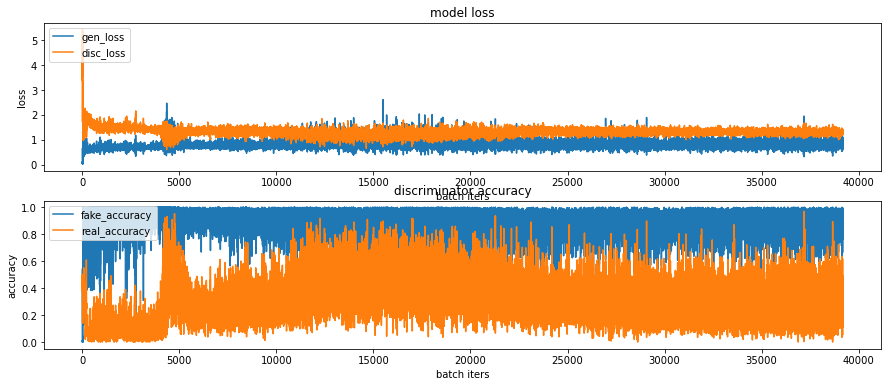

CPU times: user 1h 52min 51s, sys: 1min 50s, total: 1h 54min 42s
Wall time: 1h 53min 49s


In [22]:
%%time
train(train_dataset, EPOCHS, save_every)

**오차역전파(Backpropagation)**에서 Generator을 가중치에 2번 업데이트 하는 방식으로 진행했습니다.   

- 결과를 보면 위의 과정보다는 그래프가 더 안정적으로 수렴하는듯 보이지만, 이미지가 위에서 했던 결과보다도 제대로 나오지 않고 있네요.  

###  generator 가중치 2번 업데이트, discriminator 가중치 1번 업데이트  
- 결과 : 그래프를 보면 real_acc가 0.5 주변에서 수렴하고 fake_acc가 1에서 0.6 정도로 수렴하는 비교적 안정적인 그래프를 확인할 수 있습니다.

- 그림을 보면 (1,1)은 자동차의 특징을 가진것 같고 (1,2)와 (4,3)을 보면 얇은 다리가 보이는데 새의 다리를 학습한 것으로 보이네요. 

---

## 회고

- GAN에 대해선 많이 들어봤지만, 생각보다 더 어려워서 당황해하며 프로젝트를 진행한 것 같습니다.  


- GAN을 진행하면서 다양한 모델의 구조를 더 직접적으로 만들어 보는 기회가 있었던것 같습니다.  어려웠지만, 나름대로 이미지가 생성되고 그럴싸하게 바뀌는 모습을 보니 힘들지만 재밌게 프로젝트를 한 것 같습니다.
